In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.special import softmax
import pandas as pd

def slog(X, tol=1e-300):
    """Safe log function (avoids underflow for small values)

    ### Parameters
    1. X : str
        - input you wish to take the log of

    ### Returns
    - log(X)
        - the log of the maximum between X and tol
    """
    return np.log(np.clip(X, a_min=tol, a_max=None))


In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin


class eSPA_demo(BaseEstimator, ClassifierMixin):

    def __init__(self, K=3, epsC=1e-3, epsW=1e-2, max_iters=200, tol=1e-8):
        self.K = K
        self.epsC = epsC
        self.epsW = epsW
        self.max_iters = max_iters
        self.tol = tol
        self._is_fitted = False
        
    def fit(self,X,y):

        if self._is_fitted:
            return self.fine_tune(X,y)
        
        T,D = X.shape
        
        # Convert to one-hot encoding
        self.classes = np.unique(y)
        Pi = np.zeros((T, len(self.classes)))
        for idx,c in enumerate(self.classes):
            Pi[y==c,idx]=1
        
        # Initialize C,G,W and L
        self.C = X[np.random.randint(0, T, self.K),:]
        self.G = np.zeros((T, self.K))
        self.W = np.random.rand(D) + 0.1
        self.W /= self.W.sum()
        self.L = np.random.rand(len(self.classes), self.K)


        self.hist_W = []
        self.hist_C = []
        self.hist_G = []
        self.hist_L = []
        self.hist_pred = []
        res = 50
        grid_1d = np.linspace(0, 1.0, res)

        [xx,yy] = np.meshgrid(grid_1d,grid_1d)

        X_grid = np.column_stack((yy.flatten(), xx.flatten()))

        if D>2:
            X_grid = np.hstack((X_grid, 0.5*np.ones((X_grid.shape[0],D-2))))

        self.losses = []

        for i in range(self.max_iters):

            # Update G
            self.G = cdist(X,self.C, "sqeuclidean", w=self.W) # distances between points and centroids
            self.G -= self.epsC * (np.matmul(Pi, slog(self.L)))
            mins = np.argmin(self.G, 1)
            self.G[:,:] = 0
            for m in np.unique(mins):
                self.G[mins==m,m] = 1

            # Remove empty
            emptyboxes = self.G.sum(0)==0
            if any(emptyboxes):
                self.G = self.G[:, ~ emptyboxes]
                self.C=self.C[~ emptyboxes,:]
                self.L=self.L[:,~ emptyboxes]
                self.K = self.G.shape[1]

            # Update W
            self.W[:] = 0
            for k in range(self.K):
                self.W += np.sum(self.G[:,[k]] * ((X-self.C[[k],:])**2),0)
            self.W = softmax(-self.W/(T*self.epsW))
            
            # Update C
            self.C = (self.G.T @ X) 
            self.C /= self.G.sum(0).reshape(-1,1)

            # Update L
            self.L = Pi.T @ self.G
            sums = self.L.sum(0)
            sums[sum==0] = 1
            self.L /= sums

            # Calculate loss
            L = (self.W * ((X - self.G @ self.C)**2).sum(0)).sum() / T
            L -= (self.epsC/T) * np.sum( Pi * (slog(self.L) @ self.G.T).T)
            L += self.epsW * np.dot(self.W, slog(self.W))
            self.losses.append(L)


            self.hist_W.append(self.W.copy())
            self.hist_C.append(self.C.copy())
            self.hist_G.append(self.G.copy())
            self.hist_L.append(self.L.copy())
            self.hist_pred.append(self.predict(X_grid).T)

            if i>1 and self.losses[-2] - self.losses[-1] < 1e-8:
                break
            
        self.iterations = i

    def predict_proba(self, X):
        G = cdist(X,self.C, "sqeuclidean", w=self.W)
        mins = np.argmin(G, 1)
        G[:,:] = 0
        for m in np.unique(mins):
            G[mins==m,m] = 1
        return self.L @ G.T #M times T matrix
        
    def predict(self, X):
        G = cdist(X, self.C, "sqeuclidean", w=self.W)
        mins = np.argmin(G, axis=1)
        G[:, :] = 0
        for m in np.unique(mins):
            G[mins == m, m] = 1
        probs = self.L @ G.T  # shape (num_classes, num_samples)
        preds = np.argmax(probs, axis=0)  # max Wahrscheinlichkeit pro Sample
        return preds

In [135]:
from sklearn.metrics import make_scorer, roc_auc_score
X = pd.read_pickle("X.pkl")
X = X.values
y = pd.read_pickle("y.pkl")
y = np.ravel(y)
print(y)
mod = eSPA_demo(K=20, epsC=10, epsW=2)
mod.fit(X,y)
predprob = mod.predict_proba(X)

print(predprob[1,:])
print(y.shape)
score = roc_auc_score(y, predprob[1,:])
print(score)

[1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 1 1 1 1 0 0 0 1 1 0 0 0 0 0
 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 1
 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0.
 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1

In [144]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import StratifiedKFold

inner_cv = StratifiedKFold(n_splits=5)
param_grid = {
    'K': [2, 3, 4,5,6,7,8,9,10,11,12,13,14,15,20,25,30],
    'epsC': [2,3,4,5,6,7,8,9,10,15,20,30,1, 1e-1, 1e-2, 1e-3],
    'epsW': [8,7,6,5,3,2,1, 1e-1, 1e-2, 1e-3]
}


def my_grid_search(X, y, param_grid, cv=5):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
    # Alle Kombinationen erstellen
    from itertools import product
    keys = list(param_grid.keys())
    values = list(param_grid.values())
    param_combinations = list(product(*values))
    
    best_score = -np.inf
    best_params = None
    all_results = []
    
    for comb in param_combinations:
        params = dict(zip(keys, comb))
        auc_scores = []
        
        for train_idx, test_idx in skf.split(X, y):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            model = eSPA_demo(**params)
            model.fit(X_train, y_train)
            
            # Wahrscheinlichkeiten für die positive Klasse (hier Klassenindex 1)
            proba = model.predict_proba(X_test)

            auc = roc_auc_score(y_test, proba[1,:])
            auc_scores.append(auc)
        
        mean_auc = np.nanmean(auc_scores)
        all_results.append((params, mean_auc))
        
        if mean_auc > best_score:
            best_score = mean_auc
            best_params = params
        #print(comb)
        #print(auc_scores)
        
    return best_params, best_score, all_results
def nested_cv(X, y, param_grid, outer_splits, inner_splits):
    outer_cv = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=42)
    outer_scores = []
    outer_best_params = []

    for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
        print(f"Outer Fold {fold_idx+1}/{outer_splits}")
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Inner Grid Search
        best_params, best_score, _ = my_grid_search(X_train, y_train, param_grid, cv=inner_splits)
        outer_best_params.append(best_params)

        # Train model with best params on full inner train
        model = eSPA_demo(**best_params)
        model.fit(X_train, y_train)
        proba = model.predict_proba(X_test)

        auc = roc_auc_score(y_test, proba[1,:])
        
        outer_scores.append(auc)

    return outer_scores

#best_params, best_score, all_results = my_grid_search(X, y, param_grid)
nested_cv_scores = nested_cv(X,y, param_grid, 10, 5)



Outer Fold 1/10
Outer Fold 2/10
Outer Fold 3/10
Outer Fold 4/10
Outer Fold 5/10
Outer Fold 6/10
Outer Fold 7/10
Outer Fold 8/10
Outer Fold 9/10
Outer Fold 10/10


[np.float64(0.8083333333333332), np.float64(0.5333333333333333), np.float64(0.825), np.float64(0.5972222222222222), np.float64(0.5833333333333333), np.float64(0.8918128654970761), np.float64(0.7485380116959065), np.float64(0.5116959064327485), np.float64(0.540625), np.float64(0.525)]


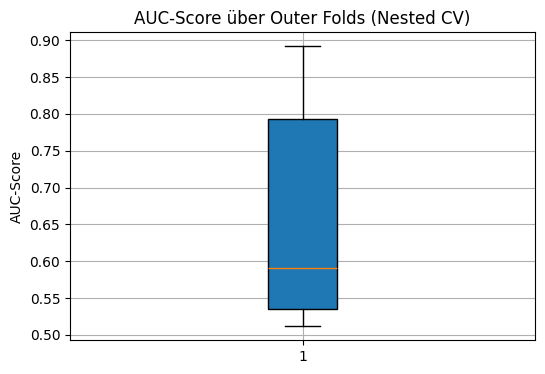

In [146]:
import matplotlib.pyplot as plt
print(nested_cv_scores)
plt.figure(figsize=(6, 4))
plt.boxplot(nested_cv_scores, vert=True, patch_artist=True)
plt.title('AUC-Score über Outer Folds (Nested CV)')
plt.ylabel('AUC-Score')
plt.grid(True)
plt.show()